In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""
import tensorflow as tf
import pickle
import tensorflow.keras as keras
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.layers.experimental import preprocessing
#from keras import backend as K
import numpy as np
#import pandas as pd
import sys
import time
import math
sys.path.append(os.path.abspath('../'))
import helpers
import helpers.data_generator
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
# from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
# from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
#from utils.callbacks import CyclicLR, TensorBoardWrapper
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import r2_score
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import linear_model

In [2]:
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

In [3]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 2
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8

In [4]:
def convert_attrs(f):
    for key in f:
        s = f[key]
        if isinstance(s, str):
            f[key] = np.string_(s)

def convert_groups(f):
    convert_attrs(f.attrs)
    for key in f:
        s = f[key]
        if isinstance(s,str):
            f[key] = np.string_(s)
        elif isinstance(s, h5py.Group):
            convert_groups(f[key])

def convert_h5py(file_in, file_out=None):
    if file_out:
        shutil.copy(file_in, file_out)
    else:
        file_out = file_in
    f = h5py.File(file_out, 'a')
    convert_groups(f)
    f.close()

In [5]:
"""THIS IS THE ONE FROM THE PAPER AS OF 3/5"""
import h5py
import shutil
import numpy as np
import sys

file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'

base_path = os.path.expanduser('/projects/EKOLEMEN/profile_predictor/run_results_03_10/')
"""good but overfit"""
#model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_01Mar20-19-50_Scenario-93.h5'
"""good val but looks bad?"""
# model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_01Mar20-02-31_Scenario-71.h5'

model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5'
file_path = base_path + model_path

convert_h5py(file_path)

model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5
loaded dict: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265_params.pkl
with parameters: dict_keys(['model_type', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'sample_weightin', 'scalar_input_names', 'std_activation', 'batch_size', 'process_data', 'predict_deltas', 'epochs', 'loss_function', 'actuator_names', 'profile_downsample', 'sample_weighting', 'loss_function_kwargs', 'flattop_only', 'raw_data_path', 'invert_q', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac', 'val_idx', 'nshots', 'excluded_shots', 'lookbac

In [6]:
orig_data_path = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
_, traindata, normalization_dict = helpers.data_generator.process_data(orig_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      invert_q=scenario.setdefault('invert_q',False),
                                                      val_idx = 0)

traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])


Loading
Signals: curr_target, dens, density_estimate, kappa_EFIT01, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  6378
Number of shots used:  6378
Total number of timesteps:  671222
Shots with Complete NaN: 
454582 samples total
Removing ECH
Removed 194246 samples
260336 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 52091 samples
208245 samples remaining
Removing weird I-coils
Removed 46528 samples
161717 samples remaining
Removing NaN
Removed 0 samples
161717 samples remaining
Removing dudtrip
Removed 9571 samples
152146 samples remaining
152146 samples remaining after pruning


Normalizing:  58%|#####8    | 14/24 [00:00<00:00, 134.04it/s]

Total number of samples:  152146
Number of training samples:  137014
Number of validation samples:  15132


Normalizing: 100%|##########| 24/24 [00:00<00:00, 95.70it/s] 


In [7]:
traindatafull = copy.deepcopy(traindata)
#traindata = {sig:traindatafull[sig][:,-1,::2] for sig in scenario['target_profile_names']}

In [8]:
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = 'std') #scenario['shuffle_generators'])

In [9]:
train_generator_batch = DataGenerator(traindatafull,
                                128, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                #all_profiles,
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                #all_profiles,
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                shuffle=False,
                                sample_weights = None) #scenario['shuffle_generators'])

In [10]:

orig_data_path = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
testdata, valdata, test_normalization_dict = helpers.data_generator.process_data(test_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      invert_q=scenario.setdefault('invert_q',False),
                                                      val_idx = 1)

testdata = helpers.normalization.renormalize(helpers.normalization.denormalize(testdata.copy(),test_normalization_dict),scenario['normalization_dict'])

Loading
Signals: curr_target, dens, density_estimate, kappa_EFIT01, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  1116
Number of shots used:  1116
Total number of timesteps:  124182
Shots with Complete NaN: 
85701 samples total
Removing ECH
Removed 46375 samples
39326 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 5176 samples
34150 samples remaining
Removing weird I-coils
Removed 7495 samples
26655 samples remaining
Removing NaN
Removed 0 samples
26655 samples remaining
Removing dudtrip
Removed 620 samples
26035 samples remaining
26035 samples remaining after pruning


Normalizing:   0%|          | 0/24 [00:00<?, ?it/s]

Total number of samples:  26035
Number of training samples:  23469
Number of validation samples:  2566


Normalizing: 100%|##########| 24/24 [00:00<00:00, 54.83it/s]


In [11]:
testdata = copy.deepcopy(traindata)
testdatafull = copy.deepcopy(testdata)

In [12]:
inputs = {sig:[] for sig in scenario['target_profile_names']}
baseline = {sig:[] for sig in scenario['target_profile_names']}
predictions = {sig:[] for sig in scenario['target_profile_names']}
for i in range(len(train_generator_batch)):
    print(i,end=',')
    sample = train_generator_batch[i]
    out = model.predict(sample[0])
    for i, sig in enumerate(scenario['target_profile_names']):
        inputs[sig].append(sample[0]["input_"+sig][:,0,:])
        if scenario['predict_deltas']:
            baseline[sig].append(sample[1]['target_'+sig])
            predictions[sig].append(out[i])
        else:
            baseline[sig].append(sample[1]['target_'+sig].squeeze() - sample[0]['input_'+sig].squeeze())
            predictions[sig].append(out[i].squeeze() - sample[0]['input_'+sig].squeeze())
inputs = {sig:np.concatenate(inputs[sig],axis=0) for sig in scenario['target_profile_names']}
baseline = {sig:np.concatenate(baseline[sig],axis=0) for sig in scenario['target_profile_names']}
predictions = {sig:np.concatenate(predictions[sig],axis=0) for sig in scenario['target_profile_names']}
model_err = {sig: (predictions[sig] - baseline[sig]) for sig in scenario['target_profile_names']}
model_err_abs = {sig: np.abs(predictions[sig] - baseline[sig]) for sig in scenario['target_profile_names']}

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,

In [13]:
inputs = {sig:[] for sig in scenario['target_profile_names']}
for i in range(len(train_generator_batch)):
    print(i,end=',')
    sample = train_generator_batch[i]
    out = model.predict(sample[0])
    for i, sig in enumerate(scenario['target_profile_names']):
        inputs[sig].append(sample[0]["input_"+sig][:,0,:])
#print(inputs)
#print(inputs2)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,

In [14]:
num_components=5
full_pca_fitter_errs = {}
full_pca_fitter_errs_abs = {}
#full_pca_fitter_preds = {}
profiles=scenario['target_profile_names']

#delta_pca_fitters = {}

for index in range(5):
    print((profiles[index]))
    comp = str(profiles[index])
    print(model_err[comp])
    full_err = model_err[comp]
    full_err_abs = model_err_abs[comp]
    #full_pred = predictions[comp]
    full_pca_fitter_errs[comp] = decomposition.IncrementalPCA(n_components=num_components).fit(full_err)
    print(profiles[index], ' done full')
    full_pca_fitter_errs_abs[comp] = decomposition.IncrementalPCA(n_components=num_components).fit(full_err_abs)
    print(profiles[index], ' abs done full')
    #full_pca_fitter_preds[comp] = decomposition.IncrementalPCA(n_components=num_components).fit(full_pred)
    #print(profiles[index], ' pred done full')
print(len(full_err))
print(len(full_err[0]))
print(len(full_err_abs))
print(len(full_err_abs[0]))
print(len(full_pca_fitter_errs['dens'].components_))
print(len(full_pca_fitter_errs['dens'].components_[0]))

dens
[[-0.19180018 -0.19223382 -0.19641    ... -0.1098849  -0.03226414
  -0.02188841]
 [-0.04788183 -0.04380316 -0.02780151 ... -0.13400435 -0.06712969
  -0.0219873 ]
 [-0.19918956 -0.19252217 -0.16520602 ... -0.05804759 -0.02607564
  -0.00591739]
 ...
 [-0.00967059 -0.02349222 -0.03609447 ...  0.00894898 -0.05536464
  -0.01310792]
 [ 0.45544082  0.40400484  0.43631965 ... -0.3612314   0.0998171
   0.26035857]
 [ 0.37330484  0.33624047  0.34815532 ... -0.5923833   0.12958777
   0.27777666]]
dens  done full
dens  abs done full
temp
[[ 0.03571695  0.04044792  0.04166755 ... -0.05088061 -0.0115652
  -0.01501356]
 [-0.02424086 -0.02715341 -0.02706452 ... -0.08517347 -0.01160568
  -0.00417025]
 [ 0.01665614  0.01156141  0.01163541 ... -0.07048777 -0.02403783
  -0.00318289]
 ...
 [ 0.07307532  0.06901826  0.06557326 ... -0.00097628 -0.01369146
  -0.00068536]
 [ 0.14601958  0.1615026   0.13167536 ... -0.14613988  0.00684169
  -0.04435905]
 [ 0.02700865  0.0272752  -0.00186205 ... -0.13474742 

In [15]:
num_components=5
full_pca_fitters = {}
full_profiles = {}
#delta_pca_fitters = {}

for profile in profiles:
    full = np.array([train_generator[i][0]['input_' + profile] for i in range(len(train_generator))]).squeeze()
    #delta = np.array([train_generator[i][1]['target_' + profile] for i in range(len(train_generator))]).squeeze()
    #print(profile, ' made arrays')
    full_profiles[profile] = full
    full_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(full)
    print(profile, ' done full')
    #delta_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(delta)
    #print(profile, ' done deltas')

dens  done full
temp  done full
q_EFIT01  done full
rotation  done full
press_EFIT01  done full


In [16]:
print(len(model_err['dens']))
print(len(model_err['dens'][0]))

15132
33


In [17]:
'''coefficients of PCA decomposition'''
# for profile in profiles:
#     print("Coeffs for " + profile +": " + decomposition.IncrementalPCA(n_components=num_components).fit_transform(full))
#     print("Coeffs for errors in " + profile +": " + decomposition.IncrementalPCA(n_components=num_components).fit_transform(full_errs))
#     print("Coeffs for abs errors in " + profile +": " + decomposition.IncrementalPCA(n_components=num_components).fit_transform(full_errs_abs))

# for profile in profiles:
#     for sig in scenario['target_profile_names']:   
#         print(full_pca_fitters[profile].transform(traindata[sig]))

coeff_og = {}
coeff_err = {}
coeff_err_abs = {}
for profile in profiles:
    full = np.array([train_generator[i][0]['input_' + profile] for i in range(len(train_generator))]).squeeze()
    coeff_og[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(full)
    coeff_err[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(model_err[profile])
    coeff_err_abs[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(model_err_abs[profile])

print(len(coeff_og))
print(len(coeff_og['dens']))
print(len(coeff_og['dens'][0]))
print(len(coeff_err))
print(len(coeff_err['dens']))
print(len(coeff_err['dens'][0]))

5
15132
5
5
15132
5


In [18]:
'''chop off last three pca modes of the pressure profile'''
#coeff_og = np.concatenate((coeff_og[profiles[0]], coeff_og[profiles[1]], coeff_og[profiles[2]], coeff_og[profiles[3]], coeff_og[profiles[4]][:, 0:2]), axis=1)
coeff_og_sliced = coeff_og.copy()
coeff_og_sliced['press_EFIT01'] = coeff_og['press_EFIT01'][:, 0:2]
coeff_err_sliced = coeff_err.copy()
coeff_err_sliced['press_EFIT01'] = coeff_err['press_EFIT01'][:, 0:2]
#print(coeff_og['press_EFIT01'])
print(len(coeff_og['press_EFIT01']))
print(len(coeff_og['press_EFIT01'][0]))
print(len(coeff_og['temp']))
print(len(coeff_og['temp'][0]))
print(len(coeff_og_sliced['press_EFIT01']))
print(len(coeff_og_sliced['press_EFIT01'][0]))
print(len(coeff_og_sliced['temp']))
print(len(coeff_og_sliced['temp'][0]))

15132
5
15132
5
15132
2
15132
5


In [56]:
print(len(full_profiles['dens']))
print(len(full_profiles['dens'][0]))
print(len(baseline['dens']))
print(len(baseline['dens'][0]))

15132
33
15132
33


In [19]:
'DNN using full profiles to predict model errs'
dataset = []
counter = 0
    
#dataset: 33 profs for dens, 33 profs for temp, etc. Then 33 errs for dens, etc. 
#15132x330 (165 for inputs, 165 for errors)
for profile in profiles:
    if counter == 0:
        dataset = full_profiles[profile+""]
    else:
        dataset = np.concatenate((dataset, full_profiles[profile+""]), axis=1)
    counter +=1
    
for profile in profiles:
    dataset = np.concatenate((dataset, np.abs(model_err[profile+""])), axis=1)

ds = pd.DataFrame(dataset)
#print(ds)

train_dataset = ds.sample(frac=0.9, random_state=0)
test_dataset = ds.drop(train_dataset.index)

train_features = train_dataset.copy()
#print(train_features)
#print(type(train_features))
test_features = test_dataset.copy()

#normalizer = preprocessing.Normalization(axis=-1)
#normalizer.adapt(train_features.to_numpy())

In [57]:
datasetb = []
datasetp = []
counter=0
for profile in profiles:
    if counter == 0:
        datasetb = baseline[profile+""]
        datasetp = predictions[profile+""]
    else:
        datasetb = np.concatenate((datasetb, baseline[profile+""]), axis=1)
        datasetp = np.concatenate((datasetp, predictions[profile+""]), axis=1)
    counter +=1

In [61]:
ds_base = pd.DataFrame(datasetb)
ds_pred = pd.DataFrame(datasetp)
train_base = ds_base.sample(frac=0.9, random_state=0)
test_base = ds_base.drop(train_base.index)
train_pred = ds_pred.sample(frac=0.9, random_state=0)
test_pred = ds_pred.drop(train_pred.index)
print(len(test_base))
print(len(test_base[0]))
print(len(test_pred))
print(len(test_pred[0]))
print(len(test_dataset))
print(len(test_dataset[0]))

1513
1513
1513
1513
1513
1513


In [20]:
import tensorflow as tf
import pickle
import tensorflow.keras as keras
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.layers.experimental import preprocessing

def custom_loss_function(y_actual, y_predicted):
    err = y_actual-y_predicted
    is_neg_err = tf.abs(err) < 0
    neg_err_loss = 0.1 * err**2
    pos_err_loss = err**2

    return tf.where(is_neg_err, neg_err_loss, pos_err_loss)

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3)

In [22]:
'''DNN'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

In [23]:
test_results = {}
test_results['165.330.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

,Custom loss [model_err]
165.330.330.165.100e.0.5lr,0.005032


In [24]:
y = dnn_err_model.predict(test_features.to_numpy()[:, 0:165])
y2 = dnn_err_model.predict(test_features.to_numpy()[:, 165:])
print(len(y))
print(len(y[0]))
print(y)

1513
165
[[0.01416322 0.00603547 0.01179231 ... 0.         0.         0.        ]
 [0.12289877 0.11774647 0.1002434  ... 0.         0.         0.        ]
 [0.13130671 0.12375835 0.10933559 ... 0.         0.         0.        ]
 ...
 [0.0385327  0.04061574 0.04089837 ... 0.         0.         0.        ]
 [0.04741207 0.04913687 0.04567723 ... 0.         0.         0.        ]
 [0.04119675 0.04539103 0.03989696 ... 0.         0.         0.        ]]


In [29]:
print(len(full_pred))
print(len(full_pred[0]))
print(len(full_pca_fitter_preds['dens'].components_))
print(len(full_pca_fitter_preds['dens'].components_[0]))

1513
33
5
33


In [30]:
print(test_features.to_numpy()[:,165:198])

[[0.19180018 0.19223382 0.19641    ... 0.1098849  0.03226414 0.02188841]
 [0.02976718 0.02704049 0.02365413 ... 0.01439006 0.02995246 0.02054892]
 [0.08848594 0.08458173 0.07350092 ... 0.05693302 0.05124528 0.02754694]
 ...
 [0.00242949 0.00932822 0.018991   ... 0.02462043 0.00097087 0.07791024]
 [0.03594564 0.02224494 0.01647791 ... 0.01482156 0.02496096 0.05598267]
 [0.00967059 0.02349222 0.03609447 ... 0.00894898 0.05536464 0.01310792]]


In [25]:
num_components=5
full_pca_fitter_preds = {}
full_pca_fitter_actual = {}
full_pca_fitter_inputs = {}
profiles=scenario['target_profile_names']
indices = [0,33,66,99,132]


for index in range(5):
    i = indices[index]
    full_pred = y[:,i:i+33]
    #pca for predicted errs made by DNN using test set inputs
    full_pca_fitter_preds[profiles[index]] = decomposition.IncrementalPCA(n_components=num_components).fit(full_pred)
    print(profiles[index], ' pred done full')
    #pca for actual errs in DNN test set
    full_actual = test_features.to_numpy()[:,165+i:165+i+33]
    full_pca_fitter_actual[profiles[index]] = decomposition.IncrementalPCA(n_components=num_components).fit(full_actual)
    print(profiles[index], ' actual done full')
    full_input = test_features.to_numpy()[:,i:i+33]
    #pca for predicted errs made by DNN using test set inputs
    full_pca_fitter_inputs[profiles[index]] = decomposition.IncrementalPCA(n_components=num_components).fit(full_input)
    print(profiles[index], ' input done full')
print(full_pca_fitter_preds['dens'].components_)

dens  pred done full
dens  actual done full
dens  input done full
temp  pred done full
temp  actual done full
temp  input done full
q_EFIT01  pred done full
q_EFIT01  actual done full
q_EFIT01  input done full
rotation  pred done full
rotation  actual done full
rotation  input done full
press_EFIT01  pred done full
press_EFIT01  actual done full
press_EFIT01  input done full
[[ 0.16284125  0.16359146  0.15674559  0.15879295  0.16167431  0.1629992
   0.16850951  0.16854838  0.16962344  0.1713525   0.17163619  0.17225034
   0.17301415  0.17441011  0.17517526  0.17667174  0.17967363  0.18234009
   0.18520235  0.18711366  0.18867205  0.19184864  0.19371077  0.19585616
   0.19624698  0.19733936  0.19916841  0.20408504  0.20437735  0.19909059
   0.14718666  0.04504222  0.03011669]
 [ 0.27572106  0.26809155  0.25019326  0.24678471  0.23271608  0.21611142
   0.20460005  0.19239977  0.17566928  0.16162697  0.14128397  0.12127546
   0.09584315  0.06848824  0.04035222  0.01607951 -0.0114185  -0.0

In [60]:
# cov = np.zeros((33,33))
# indices = [0,33,66,99,132]
# j = indices[i]
# for k in range(33):
#     cov[j,j] += (sum(np.square(y[:,j+k])))/1513
# print(len(cov))
# print(len(cov[0]))
# print(cov)
print(len(full_pca_fitter_preds['dens'].components_))
print(len(full_pca_fitter_preds['dens'].components_[0]))
tests = {}
test = y[:,0:33]
a = decomposition.IncrementalPCA(n_components=5)
a.fit_transform(test)
#a.transform(test)
print(len(a.components_))
print(len(a.components_[0]))
# b = decomposition.IncrementalPCA(n_components=5)
# b.transform(model_err)
print(type(y[:,j+165:j+165+33]))
print(len(y[:,287:]))
print(len(y[:,287:][0]))

5
33
5
33
<class 'numpy.ndarray'>
1513
0


In [26]:
'''variances of the pca coeffs of the profiles of the predictions'''
#sigma = uncertainty is dif for dif pca modes. For c_v calculation, is mu val dependent on PCA mode too?
#mu is mean of the uncertainties-- mean of the 5 diagonal entries
indices = [0,33,66,99,132]
cov = np.zeros((33,33))
A = []
var = []
std_err = {}
c_v = [] #coefficients of variation for all 5 profiles
mu = 0
sigma_mu = 0
for i in range(5):
    j = indices[i]
    y_slice = y[:,j:j+33]
#     print(len(y_slice))
#     print(len(y_slice[0]))
    cov_points = np.array([np.diag(foo) for foo in y_slice])
#     print(len(cov_points))
#     print(len(cov_points[0]))
#     print(len(cov_points[0][0]))
#     print(cov_points)
    A = decomposition.IncrementalPCA(n_components=5)
    A.fit_transform(y_slice)
    A = A.components_
    cov_pca = (A@cov_points@A.T)
    sigma_pca = np.array([np.diag(foo) for foo in cov_pca])
    #print(profiles[i]+" predicted uncertainties: ")
    #print(sigma_pca)
    #model_errs
    y_slice_model_err = test_features.to_numpy()[:,165+i:165+i+33] #abs val of model_err for profile
    num = decomposition.IncrementalPCA(n_components=5)
    num = num.fit_transform(y_slice_model_err)
    std_err[profiles[i]] = num/sigma_pca
#         #cov[k,k] += (sum(np.square(y[:,j+k])))/1513
#     #5x5-- just use the diagonals
#     #var = A @ cov @ np.transpose(A)
#     for a in range(5):
#         mu += var[i,i]**0.5
#     mu = mu/5
#     for b in range(5):
#         sigma_mu += (var[i,i]**0.5-mu)**2
#     sigma_mu = (sigma_mu/4)**0.5
#     c_v.append(sigma_mu/mu)
#     print(profiles[i] + ": ")
#     print(var)
#     print("sharpness for 1st PCA mode: " + str(var[0,0]**0.5)) #aka uncertainty?
#     print("sharpness for 2nd PCA mode: " + str(var[1,1]**0.5))
#     print("C_v: " + str(c_v))

/home/lzfang/.conda/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/lzfang/.conda/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/lzfang/.conda/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/lzfang/.conda/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/lzfang/.conda/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


In [48]:
print(len(full_pca_fitters['dens'].components_))
print(len(full_pca_fitters['dens'].components_[0]))

5
33


In [51]:
cov_points = np.array([np.diag(foo) for foo in y])
print(len(cov_points))
print(len(cov_points[0]))
print(len(baseline['dens']))
print(len(baseline['dens'][0]))

1513
165
15132
33


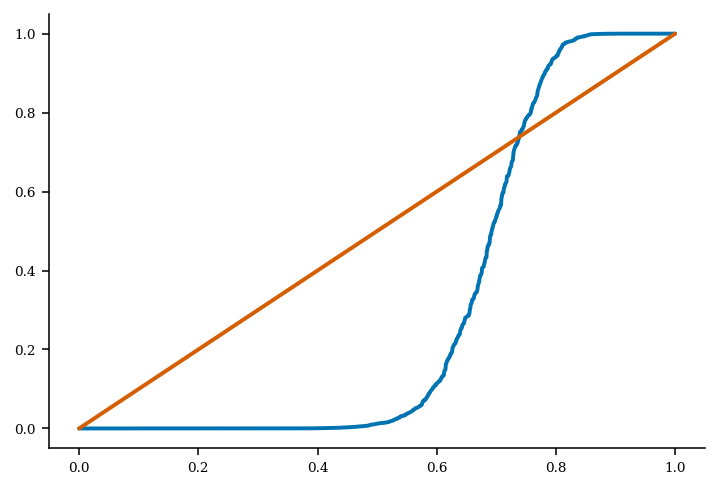

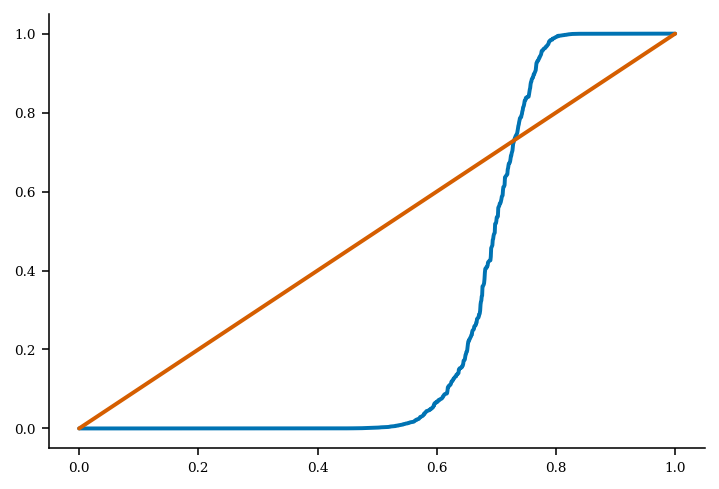

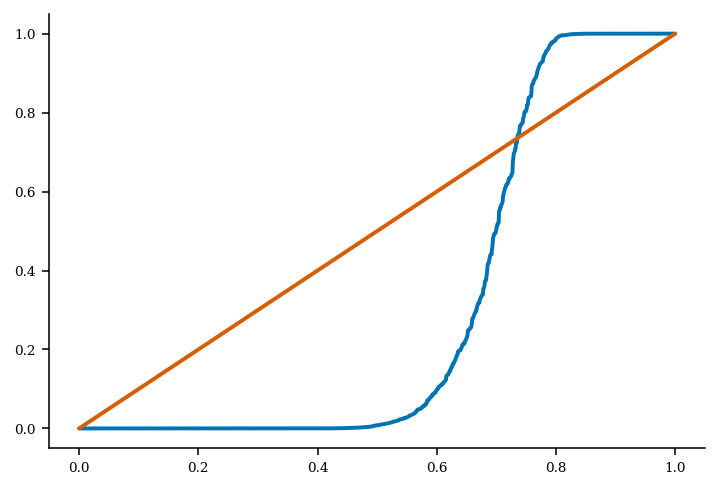

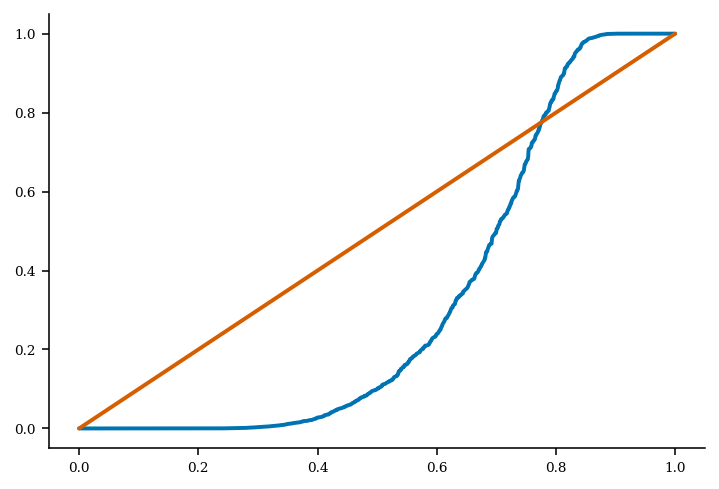

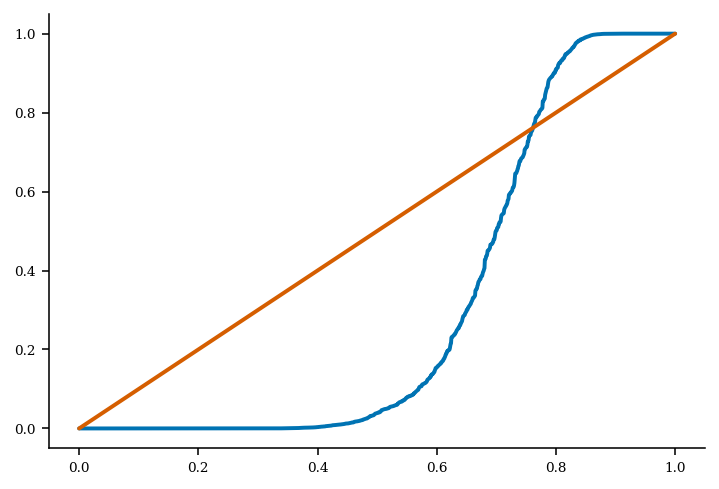

In [40]:
#make look nice-- first two PCA modes for each profile
#should we be using absolute errors/uncertainties so that CDF plot is [0,1]?
'''calibration curves'''
#first row is 1st PCA mode
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
import statsmodels
from statsmodels.distributions.empirical_distribution import ECDF
import scipy
from scipy.stats import norm
indices = [0,33,66,99,132]
for i in range(5):
    ecdf = ECDF(std_err[profiles[i]][:,0]) #first PCA mode
    pyplot.plot(ecdf.y, scipy.stats.norm.cdf(ecdf.x))
    pyplot.plot([0, 1], [0, 1]) #works for plotting diagonal
    pyplot.show()

In [29]:
print(len(sigma_pca[0]))

5


(array([1.187e+03, 2.570e+02, 4.400e+01, 1.100e+01, 9.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.1034949 , 0.20698981, 0.31048471, 0.41397961,
        0.51747452, 0.62096942, 0.72446432, 0.82795923, 0.93145413,
        1.03494903]),
 <BarContainer object of 10 artists>)

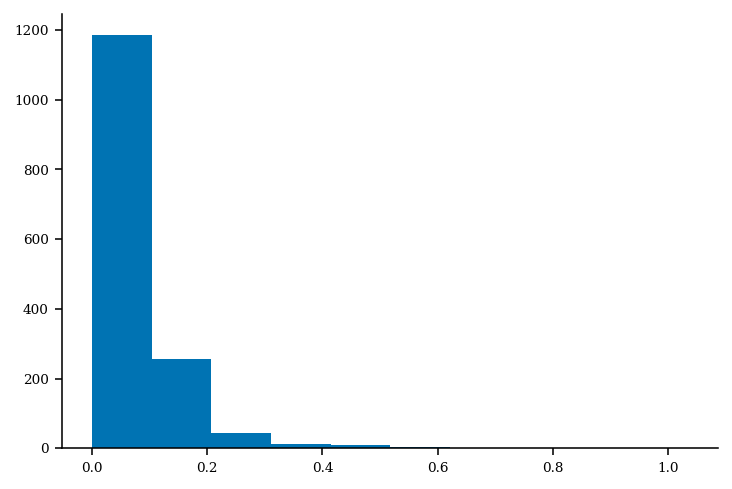

In [30]:
'''uncertainty distribution graph'''
#PLOT FOR OTHER PROFILES
#first pca mode for press_EFIT01
plt.hist(sigma_pca[:,0])

In [65]:
print(len(test_base.to_numpy()))
print(len(test_base.to_numpy()[0]))
print(test_base.to_numpy()[:,297:330])

1513
165
[]


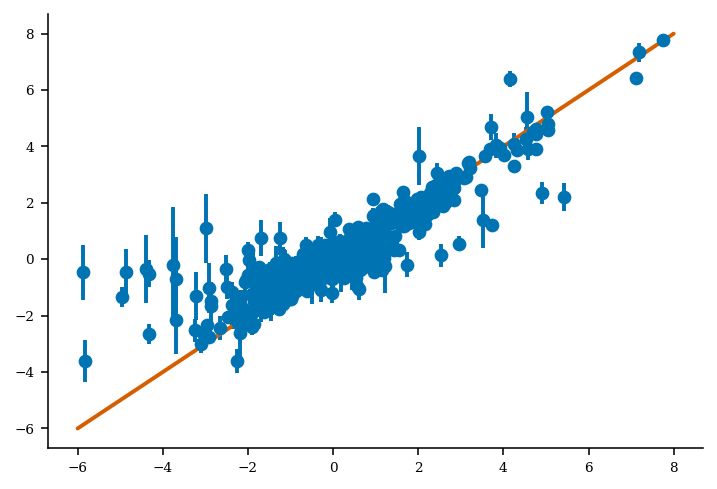

In [74]:
'''error bar plots'''
#wanna plot prediction w/err bars and test against baseline
num2 = decomposition.IncrementalPCA(n_components=5)
num2 = num2.fit_transform(test_base.to_numpy()[:,132:165])
num3 = decomposition.IncrementalPCA(n_components=5)
num3 = num3.fit_transform(test_pred.to_numpy()[:,132:165])
a_list = list(range(0, 1513))
#plt.plot(a_list,num2[:,0])
#print(num3[:,0])
#print(len(num3))
plt.errorbar(num2[:,0],num3[:,0],yerr=2*sigma_pca[:,0],fmt='o')
plt.plot([-6,8], [-6, 8])
#plt.errorbar(full_pca_fitter_inputs['dens'].components_[0,:],full_pca_fitter_preds['dens'].components_[0,:],yerr=0.10609793010075314**2, fmt="o")